In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path
import torch
import random
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
from lib import common

In [5]:
pd.options.mode.chained_assignment = None

### Path

In [6]:
path = Path('/kaggle/osic_pulmonary')
assert path.exists()

### Read Data

In [7]:
train_df, test_df, submission_df = common.read_data(path)

#### Feature generation

In [8]:
len(train_df)

1542

In [9]:
submission_df['Patient'] = submission_df['Patient_Week'].apply(lambda x:x.split('_')[0])
submission_df['Weeks'] = submission_df['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
submission_df = submission_df[['Patient','Weeks','Confidence','Patient_Week']]
submission_df = submission_df.merge(test_df.drop('Weeks', axis=1).copy(), on=['Patient'])

In [10]:
test_df[test_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker


In [11]:
train_df[train_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445107,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678810,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632984,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610394,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935764,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911224,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377335,73,Male,Ex-smoker


In [12]:
submission_df[submission_df['Patient'] == 'ID00419637202311204720264'].head(10)

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186852,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186852,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186852,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186852,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186852,73,Male,Ex-smoker
5,ID00419637202311204720264,-7,100,ID00419637202311204720264_-7,3020,70.186852,73,Male,Ex-smoker
6,ID00419637202311204720264,-6,100,ID00419637202311204720264_-6,3020,70.186852,73,Male,Ex-smoker
7,ID00419637202311204720264,-5,100,ID00419637202311204720264_-5,3020,70.186852,73,Male,Ex-smoker
8,ID00419637202311204720264,-4,100,ID00419637202311204720264_-4,3020,70.186852,73,Male,Ex-smoker
9,ID00419637202311204720264,-3,100,ID00419637202311204720264_-3,3020,70.186852,73,Male,Ex-smoker


Adding missing values

In [13]:
def add_missing_values(df, patient_id):
    resample_df = df.copy()
    resample_df = resample_df[resample_df['Patient'] == patient_id]
    resample_df_min_week = resample_df['Weeks'].min()
    resample_df_max_week = resample_df['Weeks'].max()
    resample_df = resample_df.set_index('Weeks')
    index_range = list(range(resample_df_min_week, resample_df_max_week + 1))
    resample_categories = resample_df[['Age', 'Sex', 'SmokingStatus']].reindex(index_range, method='nearest')
    resample_continuos = resample_df[['FVC', 'Percent']].reindex(index_range)
    resample_continuos = resample_continuos.interpolate()
    resample_categories[['FVC', 'Percent']] = resample_continuos
    resample_categories['Patient'] = patient_id
    return resample_categories.reset_index()

train_df_concat = pd.concat([add_missing_values(train_df, p) for p in train_df['Patient'].unique()])
train_df = train_df_concat

In [14]:
train_df_concat

,Weeks,Age,Sex,SmokingStatus,FVC,Percent,Patient
0,-4,79,Male,Ex-smoker,2315.000000,58.253647,ID00007637202177411956430
1,-3,79,Male,Ex-smoker,2303.777778,57.971256,ID00007637202177411956430
2,-2,79,Male,Ex-smoker,2292.555556,57.688866,ID00007637202177411956430
3,-1,79,Male,Ex-smoker,2281.333333,57.406475,ID00007637202177411956430
4,0,79,Male,Ex-smoker,2270.111111,57.124084,ID00007637202177411956430
...,...,...,...,...,...,...,...
55,55,73,Male,Never smoked,2824.250000,69.350998,ID00426637202313170790466
56,56,73,Male,Never smoked,2811.687500,69.042519,ID00426637202313170790466
57,57,73,Male,Never smoked,2799.125000,68.734039,ID00426637202313170790466
58,58,73,Male,Never smoked,2786.562500,68.425560,ID00426637202313170790466


In [15]:
train_df['WHERE'] = 'train'
test_df['WHERE'] = 'val'
submission_df['WHERE'] = 'test'
data = train_df.append([test_df, submission_df])

In [16]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [17]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base[base['Patient'] == 'ID00419637202311204720264']

,Patient,min_FVC,nb
0,ID00419637202311204720264,3020.0,1


In [18]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
data['base_week'] = data['base_week']
del base

In [19]:
data[data['Patient'] == 'ID00419637202311204720264']

,Weeks,Age,Sex,SmokingStatus,FVC,Percent,Patient,WHERE,Confidence,Patient_Week,min_week,min_FVC,nb,base_week
9141,6,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,train,NaN,NaN,6.0,3020.0,1,0.0
9142,7,73,Male,Ex-smoker,2859.0,66.445107,ID00419637202311204720264,train,NaN,NaN,6.0,3020.0,1,1.0
9143,8,73,Male,Ex-smoker,2821.0,65.561958,ID00419637202311204720264,train,NaN,NaN,6.0,3020.0,1,2.0
9144,9,73,Male,Ex-smoker,2783.0,64.678810,ID00419637202311204720264,train,NaN,NaN,6.0,3020.0,1,3.0
9145,10,73,Male,Ex-smoker,2719.0,63.191410,ID00419637202311204720264,train,NaN,NaN,6.0,3020.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9553,129,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_129,6.0,3020.0,1,123.0
9554,130,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_130,6.0,3020.0,1,124.0
9555,131,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_131,6.0,3020.0,1,125.0
9556,132,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_132,6.0,3020.0,1,126.0


In [20]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [21]:
data

,Weeks,Age,Sex,SmokingStatus,FVC,Percent,Patient,WHERE,Confidence,Patient_Week,min_week,min_FVC,nb,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,-4,79,Male,Ex-smoker,2315.000000,58.253647,ID00007637202177411956430,train,NaN,NaN,-4.0,2315.0,1,0.0,1,0,1,0,0
1,-3,79,Male,Ex-smoker,2303.777778,57.971256,ID00007637202177411956430,train,NaN,NaN,-4.0,2315.0,1,1.0,1,0,1,0,0
2,-2,79,Male,Ex-smoker,2292.555556,57.688866,ID00007637202177411956430,train,NaN,NaN,-4.0,2315.0,1,2.0,1,0,1,0,0
3,-1,79,Male,Ex-smoker,2281.333333,57.406475,ID00007637202177411956430,train,NaN,NaN,-4.0,2315.0,1,3.0,1,0,1,0,0
4,0,79,Male,Ex-smoker,2270.111111,57.124084,ID00007637202177411956430,train,NaN,NaN,-4.0,2315.0,1,4.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10137,129,73,Male,Never smoked,2925.000000,71.824966,ID00426637202313170790466,test,100.0,ID00426637202313170790466_129,0.0,2925.0,1,129.0,1,0,0,1,0
10138,130,73,Male,Never smoked,2925.000000,71.824966,ID00426637202313170790466,test,100.0,ID00426637202313170790466_130,0.0,2925.0,1,130.0,1,0,0,1,0
10139,131,73,Male,Never smoked,2925.000000,71.824966,ID00426637202313170790466,test,100.0,ID00426637202313170790466_131,0.0,2925.0,1,131.0,1,0,0,1,0
10140,132,73,Male,Never smoked,2925.000000,71.824966,ID00426637202313170790466,test,100.0,ID00426637202313170790466_132,0.0,2925.0,1,132.0,1,0,0,1,0


In [22]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [23]:
data['base_week'].min()

-29.0

In [24]:
train_df = data.loc[data.WHERE=='train']
test_df = data.loc[data.WHERE=='val']
submission_df = data.loc[data.WHERE=='test']
del data

In [25]:
train_df.sort_values(['Patient', 'Weeks']).head(15)

,Weeks,Age,Sex,SmokingStatus,FVC,Percent,Patient,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,-4,79,Male,Ex-smoker,2315.000000,58.253647,ID00007637202177411956430,train,NaN,NaN,...,0.0,1,0,1,0,0,0.769231,0.241456,0.179012,0.236393
1,-3,79,Male,Ex-smoker,2303.777778,57.971256,ID00007637202177411956430,train,NaN,NaN,...,1.0,1,0,1,0,0,0.769231,0.241456,0.185185,0.234121
2,-2,79,Male,Ex-smoker,2292.555556,57.688866,ID00007637202177411956430,train,NaN,NaN,...,2.0,1,0,1,0,0,0.769231,0.241456,0.191358,0.231848
3,-1,79,Male,Ex-smoker,2281.333333,57.406475,ID00007637202177411956430,train,NaN,NaN,...,3.0,1,0,1,0,0,0.769231,0.241456,0.197531,0.229576
4,0,79,Male,Ex-smoker,2270.111111,57.124084,ID00007637202177411956430,train,NaN,NaN,...,4.0,1,0,1,0,0,0.769231,0.241456,0.203704,0.227304
5,1,79,Male,Ex-smoker,2258.888889,56.841690,ID00007637202177411956430,train,NaN,NaN,...,5.0,1,0,1,0,0,0.769231,0.241456,0.209877,0.225031
6,2,79,Male,Ex-smoker,2247.666667,56.559299,ID00007637202177411956430,train,NaN,NaN,...,6.0,1,0,1,0,0,0.769231,0.241456,0.216049,0.222759
7,3,79,Male,Ex-smoker,2236.444444,56.276909,ID00007637202177411956430,train,NaN,NaN,...,7.0,1,0,1,0,0,0.769231,0.241456,0.222222,0.220486
8,4,79,Male,Ex-smoker,2225.222222,55.994518,ID00007637202177411956430,train,NaN,NaN,...,8.0,1,0,1,0,0,0.769231,0.241456,0.228395,0.218214
9,5,79,Male,Ex-smoker,2214.000000,55.712128,ID00007637202177411956430,train,NaN,NaN,...,9.0,1,0,1,0,0,0.769231,0.241456,0.234568,0.215941


In [26]:
X = train_df[FE]
X.head(15)

,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,percent,week,BASE
0,1,0,1,0,0,0.769231,0.236393,0.179012,0.241456
1,1,0,1,0,0,0.769231,0.234121,0.185185,0.241456
2,1,0,1,0,0,0.769231,0.231848,0.191358,0.241456
3,1,0,1,0,0,0.769231,0.229576,0.197531,0.241456
4,1,0,1,0,0,0.769231,0.227304,0.203704,0.241456
5,1,0,1,0,0,0.769231,0.225031,0.209877,0.241456
6,1,0,1,0,0,0.769231,0.222759,0.216049,0.241456
7,1,0,1,0,0,0.769231,0.220486,0.222222,0.241456
8,1,0,1,0,0,0.769231,0.218214,0.228395,0.241456
9,1,0,1,0,0,0.769231,0.215941,0.234568,0.241456


In [27]:
y = train_df['FVC']
y.shape

(9407,)

#### Seed

In [28]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
seed_everything(42)

### Create Dataset

In [29]:
class ArrayDataset(Dataset):
    
    def __init__(self, x, y):
        self.x, self.y = torch.tensor(x.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32)
        assert(len(self.x) == len(self.y))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __repr__(self):
        return f'x: {self.x.shape} y: {self.y.shape}'

In [30]:
def create_dl(X, y, batch_size=128, num_workers=10):
    ds = ArrayDataset(X, y)
    return DataLoader(ds, batch_size, shuffle=True, num_workers=num_workers)

In [31]:
sample_dl = create_dl(X, y)
x_sample, y_sample = next(iter(sample_dl))
x_sample.shape, y_sample.shape

(torch.Size([128, 9]), torch.Size([128]))

### Prepare neural network

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def move_to_dev(x, y):
    x = x.to(device)
    y  = y.to(device)
    return x, y

In [33]:
C1, C2 = torch.tensor(70, dtype=torch.float32), torch.tensor(1000, dtype=torch.float32)
C1, C2 = move_to_dev(C1, C2)
q = torch.tensor([0.2, 0.50, 0.8]).float().to(device)

def score(y_true, y_pred):
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = torch.max(sigma, C1)
    delta = torch.abs(y_true[:, 0] - fvc_pred)
    delta = torch.min(delta, C2)
    sq2 = torch.sqrt(torch.tensor(2.))
    metric = (delta / sigma_clip)*sq2 + torch.log(sigma_clip* sq2)
    return torch.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    e = y_true - y_pred
    v = torch.max(q*e, (q-1)*e)
    return torch.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        y_true = y_true.unsqueeze(1)
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

In [34]:
class OsicModel(torch.nn.Module):
    def __init__(self, ni, nh1, nh2):
        super(OsicModel, self).__init__()
        self.l1 = nn.Linear(ni, nh1)
        self.l1_bn = nn.BatchNorm1d(nh1, momentum=0.1)
        self.l2 = nn.Linear(nh1, nh2)
        self.p1 = nn.Linear(nh2, 3)
        self.p2 = nn.Linear(nh2, 3)
        
    def forward(self, x):
        x = self.l1(x).clamp(min=0)
        x = self.l1_bn(x)
        x = self.l2(x).clamp(min=0)
        p1 = self.p1(x)
        p2 = self.p2(x).clamp(min=0)
        preds = p1 + torch.cumsum(p2, axis=1)
        return preds

In [35]:
def create_model(nh1=100, nh2=100):
    model = OsicModel(X.shape[1], nh1, nh2)
    model = model.to(device)
    return model

In [36]:
sample_model = create_model()
sample_model

OsicModel(
  (l1): Linear(in_features=9, out_features=100, bias=True)
  (l1_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=100, out_features=100, bias=True)
  (p1): Linear(in_features=100, out_features=3, bias=True)
  (p2): Linear(in_features=100, out_features=3, bias=True)
)

In [37]:
criterion=mloss(0.8)

In [38]:
# Test model
y_sample, x_sample = move_to_dev(y_sample, x_sample)
output = sample_model(x_sample)
criterion(y_sample, output)

tensor(1131.6476, device='cuda:0', grad_fn=<AddBackward0>)

#### Training functions

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [40]:
def eval_loop(valid_dl, model):
    model.eval()
    total_eval_loss = 0
    total_eval_score = 0
    for x, y in valid_dl:
        x, y = move_to_dev(x, y)
        output = model(x)
        loss = criterion(y, output)
        total_eval_loss += loss.item()
        total_eval_score += score(y.unsqueeze(1), output)
        
    avg_val_loss = total_eval_loss / len(valid_dl)
    avg_val_score = total_eval_score / len(valid_dl) * -1
    return {
        'avg_val_loss': avg_val_loss,
        'avg_val_score': avg_val_score
    }

In [41]:
def train_loop(epochs, train_dl, valid_dl, model, lr = 1e-3):
    steps = len(train_dl) * epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
    avg_train_losses = []
    avg_val_losses = []
    avg_val_scores = []
    lr = []
    for epoch in tqdm(range(epochs), total=epochs):
        model.train()
        total_train_loss = 0.0
        for i, (x, y) in enumerate(train_dl):
            x, y = move_to_dev(x, y)
            model.zero_grad()
            output = model(x)
            loss = criterion(y, output)
            total_train_loss += loss.item()
            
            # Backward Pass and Optimization
            loss.backward()
            optimizer.step()
            scheduler.step()
            lr.append(get_lr(optimizer))
        
        avg_train_loss = total_train_loss / len(train_dl)
        avg_train_losses.append(avg_train_loss)
        eval_res = eval_loop(valid_dl, model)
        avg_val_loss = eval_res['avg_val_loss']
        avg_val_score = eval_res['avg_val_score']
        avg_val_losses.append(avg_val_loss)
        avg_val_scores.append(avg_val_score.item())
#         print(f'{epoch}: avg_val_score: {avg_val_score}')
    return pd.DataFrame({'avg_train_losses': avg_train_losses, 'avg_val_losses': avg_val_losses, 'avg_val_scores': avg_val_scores}), pd.DataFrame({'lr': lr})

In [42]:
res_df, lr_df = train_loop(100, sample_dl, sample_dl, sample_model)

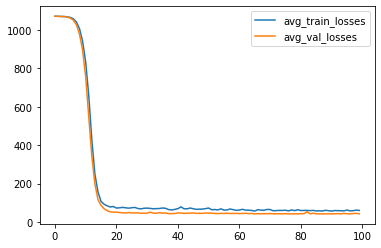

In [43]:
res_df[['avg_train_losses', 'avg_val_losses']].plot()

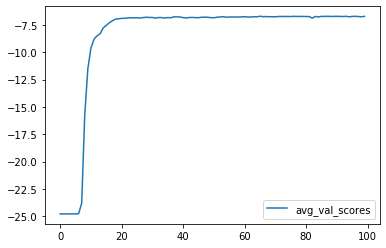

In [44]:
res_df[['avg_val_scores']].plot()

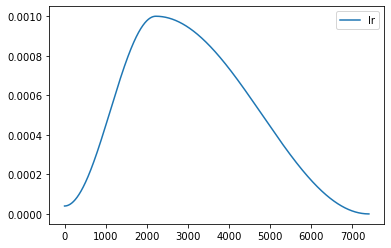

In [45]:
lr_df.plot()

In [46]:
res_df[['avg_val_scores']].max()

avg_val_scores   -6.72024
dtype: float64

#### Training

In [47]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)
EPOCHS=250

In [48]:
def convert_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32).to(device)

In [49]:
test_values = convert_to_tensor(submission_df[FE])
test_values.shape

torch.Size([730, 9])

In [50]:
pe = np.zeros((test_values.shape[0], 3))
pred = np.zeros((train_df.shape[0], 3))
pred.shape

(9407, 3)

In [51]:
def predict(features, model):
    return model(features).detach().cpu().numpy()

In [52]:
%%time

res_dfs = []
for cnt, (tr_idx, val_idx) in tqdm(enumerate(kf.split(X)), total=NFOLD):
    X_train, y_train = X.loc[tr_idx], y[tr_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    print(f"FOLD {cnt}", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    model = create_model()
    train_dl = create_dl(X_train, y_train)
    valid_dl = create_dl(X_valid, y_valid)
    res_df, _ = train_loop(EPOCHS, train_dl, valid_dl, model)
    res_dfs.append(res_df)
    pe += predict(test_values, model)
    pred[val_idx] = predict(convert_to_tensor(X_valid), model)

FOLD 0 (7525, 9) (7525,) (1882, 9) (1882,)



FOLD 1 (7525, 9) (7525,) (1882, 9) (1882,)



FOLD 2 (7526, 9) (7526,) (1881, 9) (1881,)



FOLD 3 (7526, 9) (7526,) (1881, 9) (1881,)



FOLD 4 (7526, 9) (7526,) (1881, 9) (1881,)




CPU times: user 4min 27s, sys: 5min 54s, total: 10min 22s
Wall time: 11min 15s


In [53]:
pe = pe / NFOLD

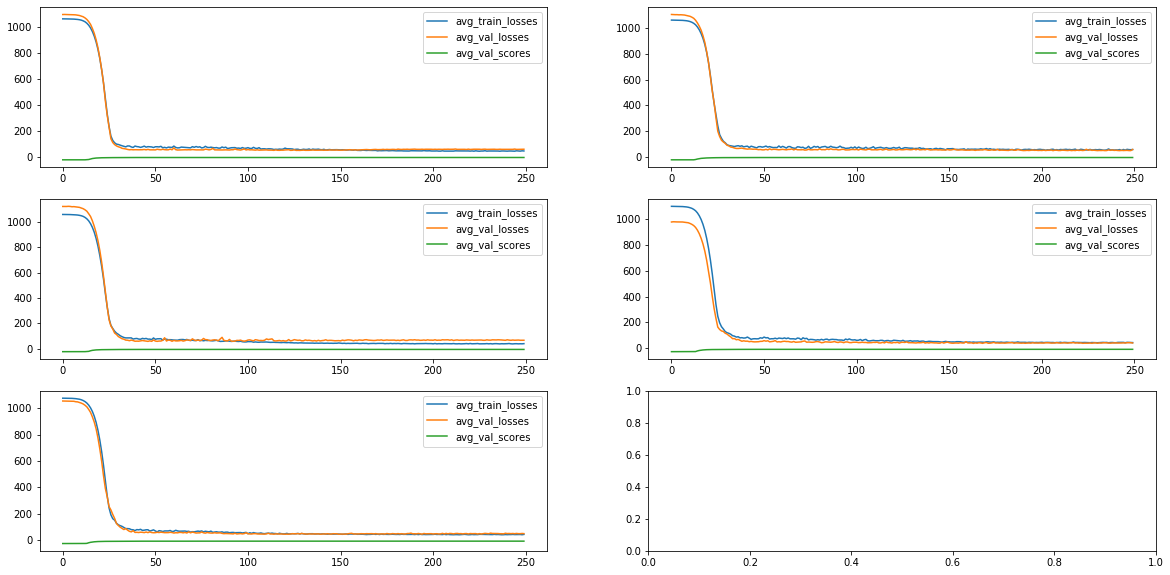

<Figure size 800x480 with 0 Axes>

In [54]:
from matplotlib.pyplot import figure

nrows = len(res_dfs) // 2 + 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
for r in range(nrows):
    for c in range(ncols):
        index = r * 2 + c
        if index < len(res_dfs):
            res_dfs[r * 2 + c].plot(ax=axes[r,c])

In [55]:
print("Mean validation score", np.mean([res_dfs[i]['avg_val_scores'][len(res_dfs[0]) - 1] for i in range(NFOLD)]))

Mean validation score -6.826086616516113


#### Prediction

In [56]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
sigma_opt, sigma_mean

(161.48826223615313, 283.8137141759253)

In [57]:
submission_df['FVC1'] = pe[:,1]
submission_df['Confidence1'] = pe[:, 2] - pe[:, 0]

In [58]:
submission_df.head(15)

,Weeks,Age,Sex,SmokingStatus,FVC,Percent,Patient,WHERE,Confidence,Patient_Week,...,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent,FVC1,Confidence1
9412,-12,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-12,...,0,1,0,0,0.615385,0.3724,0.067901,0.332421,2848.189941,320.179541
9413,-11,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-11,...,0,1,0,0,0.615385,0.3724,0.074074,0.332421,2846.529199,320.262256
9414,-10,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-10,...,0,1,0,0,0.615385,0.3724,0.080247,0.332421,2844.868408,320.345117
9415,-9,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-9,...,0,1,0,0,0.615385,0.3724,0.086420,0.332421,2843.144629,320.421680
9416,-8,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-8,...,0,1,0,0,0.615385,0.3724,0.092593,0.332421,2841.354541,320.491504
9417,-7,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-7,...,0,1,0,0,0.615385,0.3724,0.098765,0.332421,2839.564404,320.561426
9418,-6,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-6,...,0,1,0,0,0.615385,0.3724,0.104938,0.332421,2837.774170,320.631201
9419,-5,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-5,...,0,1,0,0,0.615385,0.3724,0.111111,0.332421,2835.984082,320.701367
9420,-4,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-4,...,0,1,0,0,0.615385,0.3724,0.117284,0.332421,2834.193799,320.771045
9421,-3,73,Male,Ex-smoker,3020.0,70.186852,ID00419637202311204720264,test,100.0,ID00419637202311204720264_-3,...,0,1,0,0,0.615385,0.3724,0.123457,0.332421,2832.403711,320.840869


In [59]:
subm = submission_df[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [60]:
subm.loc[~subm.FVC1.isnull()].shape, subm.shape

((730, 5), (730, 5))

In [61]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

In [62]:
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [63]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2682.151491,329.897091,2088.033716,2548.251013,2746.329126,2826.962292,3192.554102
Confidence,730.0,284.402453,37.564242,215.965576,270.960974,287.248218,320.443909,325.559131
FVC1,730.0,2682.151491,329.897091,2088.033716,2548.251013,2746.329126,2826.962292,3192.554102
Confidence1,730.0,284.402453,37.564242,215.965576,270.960974,287.248218,320.443909,325.559131


In [65]:
def replace_with_existing(df):
    for i in range(len(df)):
        patient_week_filter = subm['Patient_Week']==df.Patient[i]+'_'+str(df.Weeks[i])
        subm.loc[patient_week_filter, 'FVC'] = df.FVC[i]
        subm.loc[patient_week_filter, 'Confidence'] = 0.1

train_df = pd.read_csv(path/'train.csv', dtype = common.TRAIN_TYPES)
test_df = pd.read_csv(path/'test.csv', dtype = common.TRAIN_TYPES)
replace_with_existing(train_df)
replace_with_existing(test_df)

In [ ]:
subm[subm['Patient_Week'].str.find('ID00419637202311204720264') > -1].head(30)

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
pd.read_csv('submission.csv')

In [ ]:
!cat submission.csv